In [1]:
import numpy as np
import sympy as sp
import networkx as nx
import matplotlib as plt
from collections import Counter
import itertools
import warnings
import tqdm
import time
import functools
import matplotlib.pyplot
import numba
# import pydot
# from networkx.drawing.nx_pydot import write_dot

%matplotlib inline

In [2]:
%load_ext snakeviz

In [3]:
def plot_graph(g, pos, labels=None):
    colors = ['r' if val['peg'] else 'b' for val in  g.node.values()]
    nx.draw(g, pos=pos, node_color=colors)
    
def plot_graph_with_labels(g, pos):
    colors = ['r' if val['peg'] else 'b' for val in  g.node.values()]
    labels = {x:x for x in pos.keys()}
    
    edge_colors = [1 if g.edges[edge]['jumped'] else 0 for edge in g.edges ]
    nx.draw(g, pos=pos, node_color=colors, labels=labels, edge_cmap=plt.cm.brg, edge_color=edge_colors)

    
def plot_game(game):    
    occurences = Counter(game.node[g]['holes'] for g in game.nodes())
    
    max_holes = occurences.most_common()[0][0]
    max_board_holes = occurences.most_common()[0][1]

    hole_count = [0]*max_board_holes
    game_pos = {}
    for key in game.node:
        holes = game.node[key]['holes']
        game_pos[key] = (hole_count[holes-1], holes)
        hole_count[holes-1] += 1
    
  
    nx.draw(game, pos=game_pos)
        
    
    

In [36]:
def calc_edges(G):
    for n0, n1 in itertools.combinations(G.node, 2):

        x = G.node[n0]['x']-G.node[n1]['x']
        y = G.node[n0]['y']-G.node[n1]['y']
        if x**2 + y**2 == 1:
            angle = (sp.deg(sp.atan2(y,x))+ 360) % 180
            G.add_edge(n0, n1, angle=angle, jumped=False)

def triangle_solitaire(starting_hole = 4):
    G = nx.Graph()

    x = 0
    y = 0
    ang = sp.rad(60)

    count = 0
    for i in range(5):
        y = -i*sp.sin(ang)
        x = -i*sp.cos(ang)
        for j in range(i+1):
            G.add_node(count, peg=True, x=x, y=y)
            x += 1
            count += 1

    G.node[starting_hole]['peg'] = False    
    
    calc_edges(G)
    
    return G

def cross_solitaire(starting_hole=16):

    def add_holes(G, count, ys, xs):
        for y in ys:
            y = sp.Number(y)
            for x in xs:
                x = sp.Number(x)
                G.add_node(count, peg=True, x=x, y=y)
                count += 1
        return count
         
    G = nx.Graph()
    count = 0 
    count = add_holes(G, count,(0, 1), (2,3,4))
    count = add_holes(G, count, (2,3,4), range(7))
    count = add_holes(G, count, (5, 6), (2,3,4))
    
    G.node[starting_hole]['peg'] = False
    
    calc_edges(G)
    return G
    
G = triangle_solitaire()
G = triangle_solitaire(starting_hole=0)
# G = cross_solitaire()

In [37]:
pos = {}
for key in G.node.keys():
    x,y = list(map(lambda z: G.node[key][z].evalf(), 'xy'))
    G.node[key]['x'] = x
    G.node[key]['y'] = y
    pos[key] = (x,y)
    
    
edge_labels = {}
for key, val in G.edges:
    edge_labels[key] = val

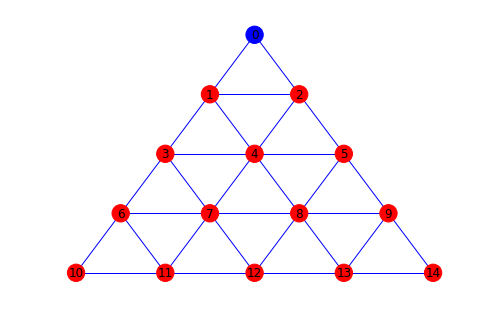

In [38]:
plot_graph_with_labels(G, pos)

In [43]:
def jumper(G):
    for n0 in G.nodes:    
        if not G.node[n0]['peg']:
            for n1, v1 in G[n0].items():
                a1 = v1['angle']
                if G.node[n1]['peg']:
                    for n2, v2 in G[n1].items():
                        a2 = v2['angle']
                        if G.node[n2]['peg'] and (n2 is not n0) and (a1 == a2):
                            
                            for n in (n0, n1, n2):
                                G.node[n]['peg'] = not G.node[n]['peg']
                
                            yield G
                            
                            for n in (n0, n1, n2):
                                G.node[n]['peg'] = not G.node[n]['peg']
                            
                            

new_graphs = jumper(G)

In [48]:
def occupancy_list(g):
    return tuple(map(lambda key: g.node[key]['peg'], sorted(g.node.keys())))

def peg_count(g):
    return sum(occupancy_list(g))

def compare_graphs(g0, g1):
     return occupancy_list(g0) == occupancy_list(g1)

def int_repr(pegs):
    x = np.uint64(0)
    for n, peg in enumerate(pegs):
        if peg:
            x += np.power(np.uint64(2), np.uint64(n) )
    return x 

def binary_repr(x, width):
    bins = np.binary_repr(x, width=width)[::-1]
    return tuple(map(bool, map(int, bins)))
    
def binary_to_graph(bins, g):
    for x, y in zip(bins, g.node):
        g.node[y]['peg'] = x
    return g

In [15]:
%%snakeviz
def exhaustive_search(G):
    game = nx.DiGraph()
    game.add_node(occupancy_list(G),holes= 1, board= G)

    current = {occupancy_list(G)}


    max_steps = G.number_of_nodes()-1
    # max_steps = 13
    for holes in range(1, max_steps):
        futures = set()
        print('holes: {:2}/{:2}\tgame count:{}'.format(holes,max_steps,len(current)))
        for current_key in current:

            current_graph = game.node[current_key]['board']
            game.add_node(occupancy_list(current_graph), holes=holes, board=current_graph)

            new_graphs = jumper(current_graph)

            for new_graph in new_graphs:
                futures.add(occupancy_list(new_graph))
                game.add_node(occupancy_list(new_graph), holes=holes+1, board=new_graph)
                game.add_edge(occupancy_list(current_graph), occupancy_list(new_graph))
#             print('holes: {:2}/{:2}\tgame count:{}'.format(holes+1,max_steps,len(futures)), end='\r')

    #     print(len(futures))
        current = futures
    
    print('')
    return game, current

t0 = time.time()
game, last_layer = exhaustive_search(G)
print('Elapsed time {:.2f}'.format(time.time() - t0))

holes:  1/14	game count:1
holes:  2/14	game count:2
holes:  3/14	game count:6
holes:  4/14	game count:21
holes:  5/14	game count:58
holes:  6/14	game count:139
holes:  7/14	game count:260
holes:  8/14	game count:350
holes:  9/14	game count:351
holes: 10/14	game count:261
holes: 11/14	game count:142
holes: 12/14	game count:49
holes: 13/14	game count:10

Elapsed time 5.04
 
*** Profile stats marshalled to file 'C:\\Users\\vikto\\AppData\\Local\\Temp\\tmpa2v2f1c_'. 


In [49]:
%%snakeviz
game = nx.DiGraph()
game.add_node(occupancy_list(G),holes= 1, board= G)

current = {int_repr(occupancy_list(G))}


total_holes = G.number_of_nodes()
max_steps = G.number_of_nodes()-1
# max_steps = 13

G_copy = G.copy()

t0 = time.time()
for holes in range(1, max_steps):
    futures = set()
    t1 = time.time()
    for current_int in current:
        current_bin = binary_repr(current_int, total_holes)
        current_graph = binary_to_graph(current_bin, G_copy)
        
        new_graphs = jumper(current_graph)

        for new_graph in new_graphs:
            new_graph = int_repr(occupancy_list(new_graph))
            if new_graph not in futures:
                futures.add(new_graph)

        if (time.time()-t1) > 1:
            print('holes: {:2}/{:2}\tgame count: {}'.format(holes+1,max_steps,len(futures)), end='\r')
            t1 = time.time()

    current = futures
    print('holes: {:2}/{:2}\tgame count: {}'.format(holes+1,max_steps,len(futures)))
    
#     return game, current

# t0 = time.time()
# game, last_layer = exhaustive_search(G)
print('Elapsed time {:.2f}'.format(time.time() - t0))

holes:  2/14	game count: 2
holes:  3/14	game count: 8
holes:  4/14	game count: 35
holes:  5/14	game count: 122
holes:  6/14	game count: 293
holes:  7/14	game count: 530
holes:  8/14	game count: 679
holes:  9/14	game count: 623
holes: 10/14	game count: 414
holes: 11/14	game count: 212
holes: 12/14	game count: 75
holes: 13/14	game count: 18
holes: 14/14	game count: 4
Elapsed time 3.21
 
*** Profile stats marshalled to file 'C:\\Users\\vikto\\AppData\\Local\\Temp\\tmpgnm_ew58'. 


In [63]:
def search(board, holes=1):
    
    count = peg_count(board)
    
    # victory condition is when only one peg is left
    if count == 1:
        yield board

    for new_board in jumper(board):
        for result in  search(new_board, len(board)-count):
            if result:
#                 print(count)
                yield result

solutions = search(G)
# victory_search(G)

In [64]:
t0 = time.time()
solution = next(solutions)
print('Elapsed time: {:.2f}'.format(time.time()-t0))
solution
plot_graph(solution, pos)

KeyboardInterrupt: 

In [54]:
t0 = time.time()
print(len(list(solutions)))
print('Elapsed time: {:.2f}'.format(time.time()-t0))


1550
Elapsed time: 171.39


In [33]:
iter_future = iter(last_layer)
len(last_layer)

4

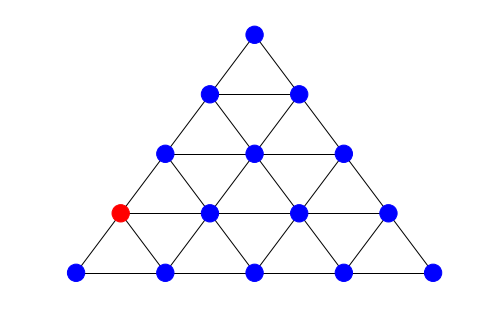

In [38]:
plot_graph(game.node[next(iter_future)]['board'], pos)

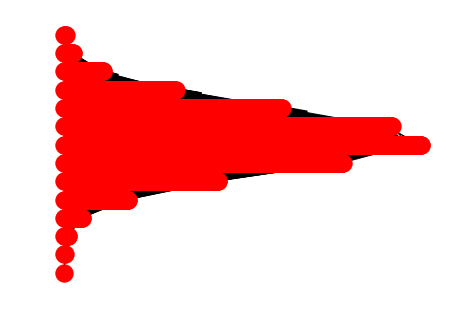

In [36]:
plot_game(game)

In [99]:
sp.factorial(15)

1307674368000

In [100]:
current_list = iter(current)

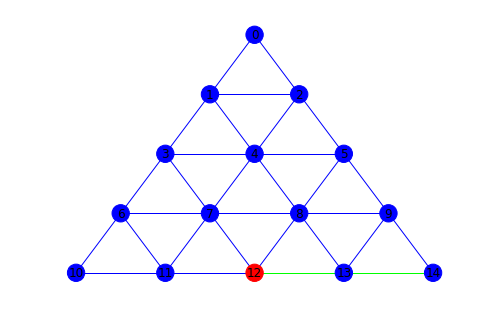

In [101]:
last_layer = game.node[next(current_list)]['board']
plot_graph_with_labels(last_layer,pos=pos)

In [102]:
print('\n'.join(map(str, current)))

(False, False, False, False, False, False, False, False, False, False, False, False, True, False, False)


In [103]:
for tt in game.node:
    tt

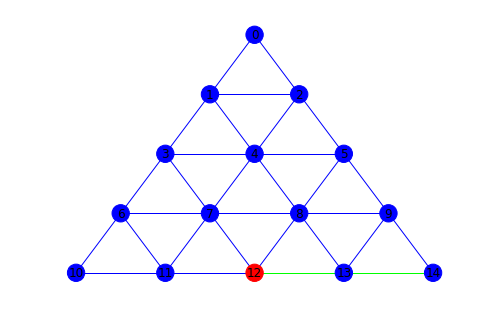

In [104]:
lastgames = list(current)
lastgame = lastgames[0]
plot_graph_with_labels(game.node[lastgame]['board'], pos)

13


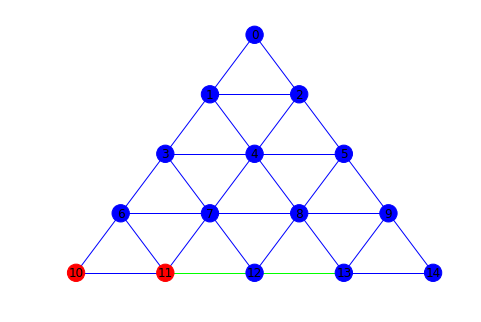

In [105]:
prev_games = next(game.predecessors(lastgame))
lastgame = prev_games
print(game.node[lastgame]['holes'])
plot_graph_with_labels(game.node[lastgame]['board'], pos)

In [106]:
path_to_victory = iter(nx.astar_path(game, occupancy_list(G), lastgame))

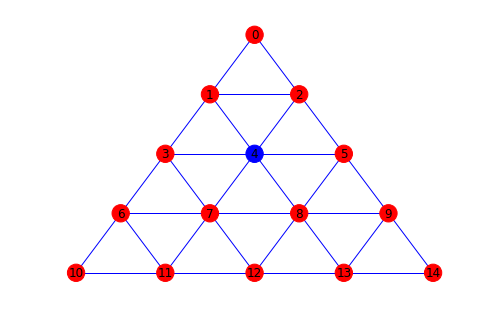